In [40]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [42]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

In [43]:
def extract_fnu_from_simulation(psimtbl):
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 't' != filte]
	return fnuabs

def extract_fnu_anwr_from_observation(pobstbl):
	fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
	return fnuabs_anwr

def extract_fnu_from_observation(pobstbl):
	fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
	fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]
	return fnuobs, fnuobserr

def calc_colors(pobstbl, bd0, bd1, bd2):
	gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
	grerr = np.sqrt(
		(pobstbl[f'magerr_{bd0}']**2)+(pobstbl[f'magerr_{bd1}']**2)
	).item()
	ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
	rierr = np.sqrt(
		(pobstbl[f'magerr_{bd1}']**2)+(pobstbl[f'magerr_{bd2}']**2)
	).item()
	return gr, grerr, ri, rierr

def calc_chisq_all(fnuabs, popt, fnuobs, fnuobserr, dof):
	chisq = calc_chisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		)

	rchisq = calc_redchisquare(
		obs=fnuabs*popt,
		exp=fnuobs,
		obserr=fnuobserr,
		dof=dof,
	)
	return chisq, rchisq

def generate_sncosmo_class(mdlname, ver, typ, z, t, peakabsmag=-19.0, peakabsfilter='bessellb'):
	"""
	peakabsfilter = 'bessellb'
	peakabsmag = -19.0
	"""
	#
	source = sncosmo.get_source(mdlname, version=ver)
	model = sncosmo.Model(source=source)
	model.set(z=z)
	model.set_source_peakabsmag(peakabsmag, peakabsfilter, 'ab')
	#
	tmin = model.mintime()
	tmax = model.maxtime()
	lmin = model.minwave()
	lmax = model.maxwave()

	#	Wavelength [AA]
	wavestep = 10
	wave = np.arange(lmin, lmax, wavestep)
	#	Time
	flux = model.flux(t, wave)
	# pflux, pwave = speclite_class.pad_spectrum(flux, wave)

	return flux, wave

In [44]:
path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc'
path_knsynpht='../3.table/kn_sim_cube_synphot'
path_knsp='../3.table/kn_sim_cube_lite'
path_snsynpht='../3.table/sn_sim_sncosmo_synphot'
path_plot='../4.plot/sed.png'
seed=0
nrow=0

In [45]:
#	LSST
lstbl = Table.read('../5.result/fit_kn2all/lsst/fit.only.detect.fits')
#	KMTNet
kmtbl = Table.read('../5.result/fit_kn2all/kmtnet/fit.only.detect.fits')
#	7DT
sdtbl = Table.read('../5.result/fit_kn2all/7dt/fit.only.detect.fits')

In [46]:
indx_select = np.where(
	(sdtbl['del_rchisq'] == sdtbl['del_rchisq'].min())
)

obs0 = str(sdtbl['obs'][indx_select].item(), 'utf-8')
popt0 = sdtbl['kn_popt'][indx_select]
angle = obs0.split('_')[-6].replace('angle', '')

obslist = []
tlist = []
for t, obs in zip(lstbl['t'], lstbl['obs']):
	obsid = obs.split('_synphot')[0]
	obs0id = obs0.split('_synphot')[0]
	if obsid == obs0id:
		print(t, obs)
		tlist.append(t)
		obslist.append(obs)


120
0.125 Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.001_vw0.3_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv
0.25 Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.001_vw0.3_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv
0.5 Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.001_vw0.3_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv
2.0 Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.001_vw0.3_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv


In [70]:
ii = 0
tt = 0
t = tlist[tt]

obstbl = ascii.read(f"../5.result/kn_sim_cube_obs/med_iter100_40Mpc/{obs0}")
print(obs0, t, 'days')

obstbl = obstbl[obstbl['seed']==0]
pobstbl = obstbl[obstbl['t']==t*u.day]

Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.01_vw0.15_angle120_synphot_med_obs_d40_iter100.med.ecsv 0.125 days


In [48]:
#	Kilonova best-fit
kn_bestfit = f"{path_knsynpht}/{str(sdtbl['kn_bestfit'][indx_select].item(), 'utf-8')}"
kn_t = sdtbl['kn_t'][nrow].item()
kn_popt = sdtbl['kn_popt'][nrow].item()
kn_rchisq = sdtbl['kn_rchisq'][nrow].item()
kn_angle = os.path.basename(kn_bestfit).split('_')[-3].replace('angle', '')

t = kn_t
times = np.unique(sdtbl['t'])
tt = np.where(times==kn_t)[0].item()

knbtbl = ascii.read(kn_bestfit)
knbtbl = knbtbl[knbtbl['t']==t]


In [49]:
# Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.001_vw0.3_spec_2020-02-29.fits
# spec = glob.glob(f"../3.table/kn_sim_cube_lite/{obs0.split('_angle')[0]}*_spec_*.fits")[0]
spec = f"../3.table/kn_sim_cube_lite/{knbtbl.meta['model']}"
sptbl = Table.read(spec)
step = 1024
ncol = int(2+int(angle)/(180/54))

lamspec = sptbl['lam'][tt*step:(tt+1)*step]*u.Angstrom
flamspec = sptbl[f'col{ncol}'][tt*step:(tt+1)*step]*(u.erg/u.second/u.Angstrom/u.cm**2)
fnuspec = convert_flam2fnu(flamspec, lamspec).to(u.uJy)
# plt.plot(lamspec, fnuspec,)

In [50]:
sdtbl.keys()

['seed',
 'obs',
 't',
 'm475-m625',
 '(m475-m625)err',
 'm625-m750',
 '(m625-m750)err',
 'kn_bestfit',
 'kn_t',
 'kn_compare_models',
 'kn_chisq',
 'kn_rchisq',
 'kn_popt',
 'kn_dof',
 'cmp_bestfit',
 'cmp_t',
 'cmp_compare_models',
 'cmp_chisq',
 'cmp_rchisq',
 'cmp_popt',
 'cmp_dof',
 'identification',
 'dshape',
 'lat',
 'md',
 'vd',
 'mw',
 'vw',
 'angle',
 'd',
 'del_rchisq',
 'cmp_model_name',
 'ver',
 'typ',
 'z']

In [59]:
kn_bestfit = f"../3.table/kn_sim_cube_synphot/{str(sdtbl['kn_bestfit'][indx_select].item(), 'utf-8')}"
kn_t = sdtbl['kn_t'][indx_select].item()
kn_popt = sdtbl['kn_popt'][indx_select].item()
kn_angle = os.path.basename(kn_bestfit).split('_')[-3].replace('angle', '')

knbtbl = ascii.read(kn_bestfit)
knbtbl = knbtbl[knbtbl['t']==t]
knbspec = knbtbl.meta['model']

knbsptbl = Table.read(f"../3.table/kn_sim_cube_lite/{knbspec}")
knbsptbl

knblam = sptbl['lam'][tt*step:(tt+1)*step]*u.Angstrom
knbflam = sptbl[f'col{ncol}'][tt*step:(tt+1)*step]*(u.erg/u.second/u.Angstrom/u.cm**2)
knbfnu = convert_flam2fnu(flamspec, lamspec).to(u.uJy)

# plt.plot(knblam, knbfnu)

cmp_bestfit = f"../3.table/sn_sim_sncosmo_synphot/{str(sdtbl['cmp_bestfit'][indx_select].item(), 'utf-8')}"
cmp_t = sdtbl['cmp_t'][indx_select].item()
cmp_popt = sdtbl['cmp_popt'][indx_select].item()
cmptbl = ascii.read(cmp_bestfit)

mdlname = cmptbl.meta['model name']
ver = '1.0'
typ = cmptbl.meta['type']
z = cmptbl.meta['z']
t = cmp_t

cmpflux, cmpwave = generate_sncosmo_class(mdlname, ver, typ, z, t)
cmpfnu = convert_flam2fnu(cmpflux*(u.erg/u.second/u.Angstrom/u.cm**2), cmpwave*u.Angstrom).to(u.uJy)

# plt.plot(cmpwave, cmpfnu)

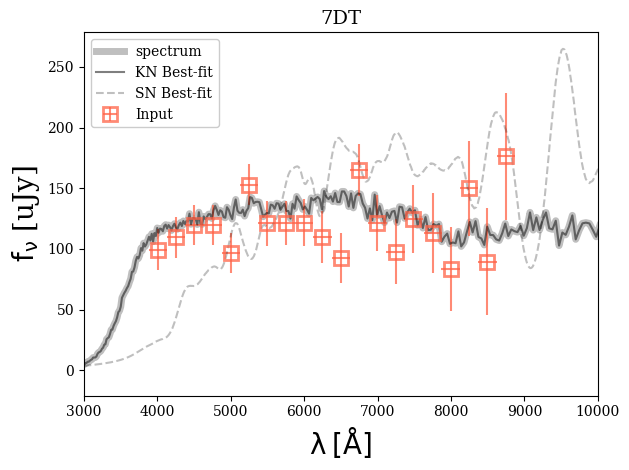

In [52]:
fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)
fnuobs_anwr = extract_fnu_anwr_from_observation(pobstbl)

plt.plot(lamspec, fnuspec*popt0, label='spectrum', lw=5, color='grey', alpha=0.5)
plt.errorbar(mlam, fnuobs, xerr=mbdw/2, yerr=fnuobserr, ls='none', ms=10, marker='s', mec='tomato', mfc='none', mew=2, c='tomato', label='Input', alpha=0.75)
plt.plot(knblam, knbfnu*kn_popt, label='KN Best-fit', c='k', alpha=0.5)
plt.plot(cmpwave, cmpfnu*cmp_popt, label='SN Best-fit', ls='--', c='k', alpha=0.25)

plt.title('7DT')
plt.xlabel(r'$\rm \lambda\:[\AA]$')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.xlim([3000, 10000])
plt.legend(loc='upper left', framealpha=1.0)
plt.tight_layout()

In [114]:
t = sdtbl['t'][indx_select].item()
times = np.unique(sdtbl['t'])
tt = np.where(t==times)[0].item()
print(t, tt)

tt = 0
times = np.unique(sdtbl['t'])
t = times[tt]
print(t, tt)

0.25 1
0.125 0


In [116]:
sdtbl['t'][indx_select]

0.25


0.125 0


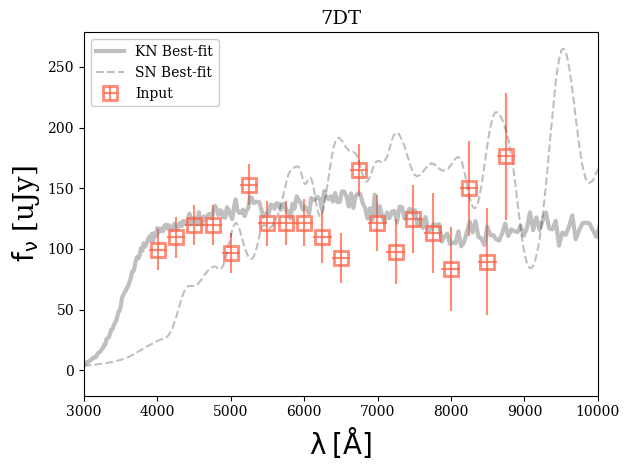

In [123]:
# def plot_routine(sdtbl, indx_select):
indx_select = np.where(sdtbl['del_rchisq'] == sdtbl['del_rchisq'].min())

obs0 = str(sdtbl['obs'][indx_select].item(), 'utf-8')
angle = obs0.split('_')[-6].replace('angle', '')

# t = sdtbl['t'][indx_select].item()
# times = np.unique(sdtbl['t'])
# tt = np.where(t==times)[0].item()
tt = 0
times = np.unique(sdtbl['t'])
t = times[tt]
print(t, tt)

obstbl = ascii.read(f"../5.result/kn_sim_cube_obs/med_iter100_40Mpc/{obs0}")
obstbl = obstbl[obstbl['seed']==0]
pobstbl = obstbl[obstbl['t']==t*u.day]

fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)
fnuobs_anwr = extract_fnu_anwr_from_observation(pobstbl)

#	Kilonova best-fit
# t = kn_t
times = np.unique(sdtbl['t'])
tt = np.where(times==kn_t)[0].item()

#	Kilonova
kn_bestfit = f"../3.table/kn_sim_cube_synphot/{str(sdtbl['kn_bestfit'][indx_select].item(), 'utf-8')}"
kn_t = sdtbl['kn_t'][indx_select].item()
kn_popt = sdtbl['kn_popt'][indx_select].item()
kn_angle = os.path.basename(kn_bestfit).split('_')[-3].replace('angle', '')

knbtbl = ascii.read(kn_bestfit)
knbtbl = knbtbl[knbtbl['t']==kn_t]
knbspec = knbtbl.meta['model']

knbsptbl = Table.read(f"../3.table/kn_sim_cube_lite/{knbspec}")

knblam = sptbl['lam'][tt*step:(tt+1)*step]*u.Angstrom
knbflam = sptbl[f'col{ncol}'][tt*step:(tt+1)*step]*(u.erg/u.second/u.Angstrom/u.cm**2)
knbfnu = convert_flam2fnu(flamspec, lamspec).to(u.uJy)

#	Comparison models
cmp_bestfit = f"../3.table/sn_sim_sncosmo_synphot/{str(sdtbl['cmp_bestfit'][indx_select].item(), 'utf-8')}"
cmp_t = sdtbl['cmp_t'][indx_select].item()
cmp_popt = sdtbl['cmp_popt'][indx_select].item()
cmptbl = ascii.read(cmp_bestfit)
##	Model parameters
mdlname = cmptbl.meta['model name']
ver = '1.0'
typ = cmptbl.meta['type']
z = cmptbl.meta['z']
t = cmp_t

cmpflux, cmpwave = generate_sncosmo_class(mdlname, ver, typ, z, t)
cmpfnu = convert_flam2fnu(cmpflux*(u.erg/u.second/u.Angstrom/u.cm**2), cmpwave*u.Angstrom).to(u.uJy)

#	Plot
plt.errorbar(mlam, fnuobs, xerr=mbdw/2, yerr=fnuobserr, ls='none', ms=10, marker='s', mec='tomato', mfc='none', mew=2, c='tomato', label='Input', alpha=0.75)
plt.plot(knblam, knbfnu*kn_popt, label='KN Best-fit', lw=3, color='grey', alpha=0.5)
plt.plot(cmpwave, cmpfnu*cmp_popt, label='SN Best-fit', ls='--', c='k', alpha=0.25)
##	Setting
plt.title('7DT')
plt.xlabel(r'$\rm \lambda\:[\AA]$')
plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
plt.xlim([3000, 10000])
plt.legend(loc='upper left', framealpha=1.0)
plt.tight_layout()

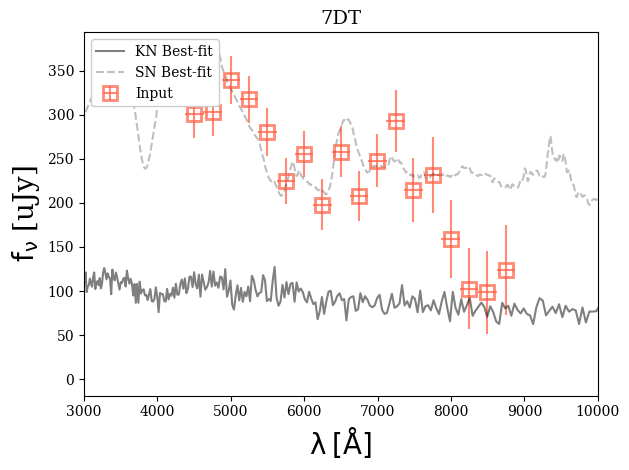

In [81]:
def plot_routine_odl(nrow, sdtbl, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_knsynpht='../3.table/kn_sim_cube_synphot', path_knsp='../3.table/kn_sim_cube_lite', path_snsynpht='../3.table/sn_sim_sncosmo_synphot', path_plot='../4.plot/sed.png', seed=0,):
	# obs0 = sdtbl['obs'][nrow]
	# popt0 = sdtbl['kn_popt'][nrow]
	# angle = obs0.split('_')[-6].replace('angle', '')

	#	Kilonova best-fit
	kn_bestfit = f"{path_knsynpht}/{sdtbl['kn_bestfit'][nrow]}"
	kn_t = sdtbl['kn_t'][nrow]
	kn_popt = sdtbl['kn_popt'][nrow]
	kn_rchisq = sdtbl['kn_rchisq'][nrow]
	kn_angle = os.path.basename(kn_bestfit).split('_')[-3].replace('angle', '')

	times = np.unique(sdtbl['t'])
	tt = np.where(times==kn_t)[0].item()

	knbtbl = ascii.read(kn_bestfit)
	knbtbl = knbtbl[knbtbl['t']==kn_t]
	knbspec = knbtbl.meta['model']
	knbsptbl = Table.read(f"{path_knsp}/{knbspec}")

	ncol = int(2+int(kn_angle)/(180/54))
	step = 1024
	knblam = knbsptbl['lam'][tt*step:(tt+1)*step]*u.Angstrom
	knbflam = knbsptbl[f'col{ncol}'][tt*step:(tt+1)*step]*(u.erg/u.second/u.Angstrom/u.cm**2)
	knbfnu = convert_flam2fnu(knbflam, knblam).to(u.uJy)

	#	Comparison model best-fit
	cmp_bestfit = f"{path_snsynpht}/{sdtbl['cmp_bestfit'][nrow]}"
	cmp_t = sdtbl['cmp_t'][nrow].item()
	cmp_popt = sdtbl['cmp_popt'][nrow].item()
	cmp_rchisq = sdtbl['cmp_rchisq'][nrow].item()
	cmptbl = ascii.read(cmp_bestfit)

	mdlname = cmptbl.meta['model name']
	ver = '1.0'
	typ = cmptbl.meta['type']
	z = cmptbl.meta['z']
	t = cmp_t

	cmpflux, cmpwave = generate_sncosmo_class(mdlname, ver, typ, z, t)
	cmpfnu = convert_flam2fnu(cmpflux*(u.erg/u.second/u.Angstrom/u.cm**2), cmpwave*u.Angstrom).to(u.uJy)

	#	Observation
	obstbl = ascii.read(f"{path_obs}/{obs0}")
	obstbl = obstbl[obstbl['seed']==seed]
	pobstbl = obstbl[obstbl['t']==sdtbl['t'][nrow].item()*u.day]

	fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)
	fnuobs_anwr = extract_fnu_anwr_from_observation(pobstbl)

	#	Plot
	# plt.plot(lamspec, fnuspec*kn_popt, label='spectrum', lw=5, color='grey', alpha=0.5)
	plt.errorbar(mlam, fnuobs, xerr=mbdw/2, yerr=fnuobserr, ls='none', ms=10, marker='s', mec='tomato', mfc='none', mew=2, c='tomato', label='Input', alpha=0.75)
	# plt.errorbar(mlam, fnuobs_anwr, xerr=mbdw/2, yerr=fnuobserr, ls='none', ms=10, marker='s', mec='dodgerblue', mfc='none', mew=2, c='dodgerblue', label='Truth', alpha=0.75)

	plt.plot(knblam, knbfnu*kn_popt, label='KN Best-fit', c='k', alpha=0.5)
	plt.plot(cmpwave, cmpfnu*cmp_popt, label='SN Best-fit', ls='--', c='k', alpha=0.25)

	plt.title('7DT')
	plt.xlabel(r'$\rm \lambda\:[\AA]$')
	plt.ylabel(r'$\rm f_{\nu}$ [uJy]')
	plt.xlim([3000, 10000])
	plt.legend(loc='upper left', framealpha=1.0)
	plt.tight_layout()

	plt.savefig(path_plot)
# nrow=0
# plot_routine(nrow, sdtbl, path_obs='../5.result/kn_sim_cube_obs/med_iter100_40Mpc', path_knsynpht='../3.table/kn_sim_cube_synphot', path_knsp='../3.table/kn_sim_cube_lite', path_snsynpht='../3.table/sn_sim_sncosmo_synphot', path_plot='../4.plot/sed.png', seed=0,)